In [2]:
library("httr")
library("jsonlite")

library(ggplot2)

library(tseries)
library(forecast)
library(rugarch)

In [7]:
url <- "https://api.iextrading.com/1.0"
ticker <- "IETC"
endpoint <- paste("/stock/", ticker, "/chart/1y", sep="")
url <- paste(url, endpoint, sep="")

length <- 200
query <- list(chartLast=length) 

request <- GET(url, query=query)
response <- content(request, as="text")
df <- fromJSON(response, flatten = TRUE) 
price <- df[c("date", "close")]
write.csv(price, "/home/carson/Desktop/price.csv", row.names=FALSE)

s <- ts(log(price$close))
ds <- diff(s)

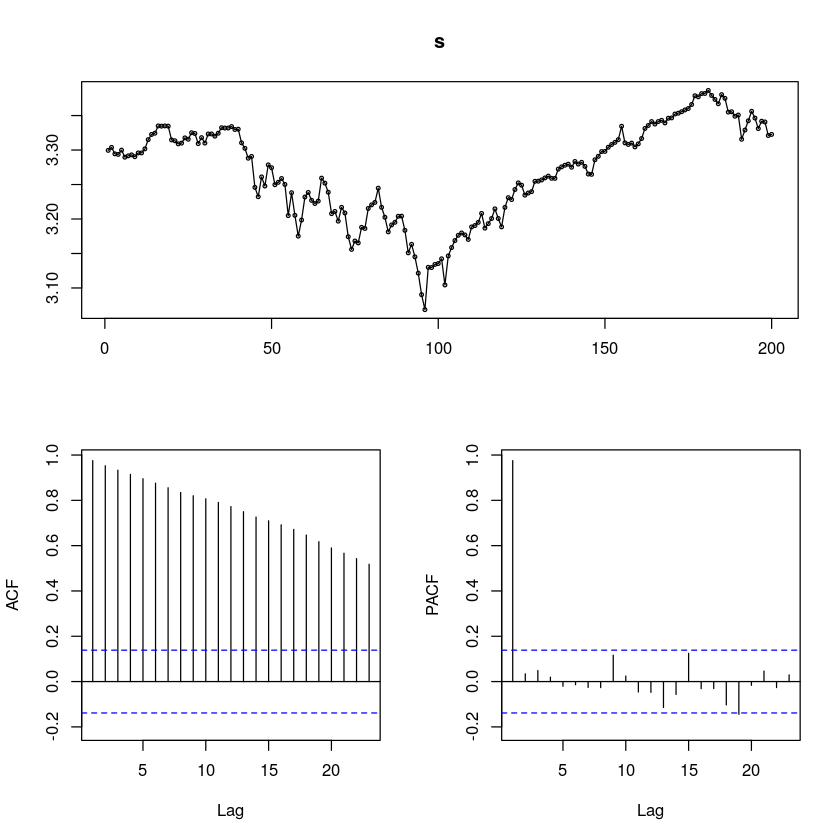

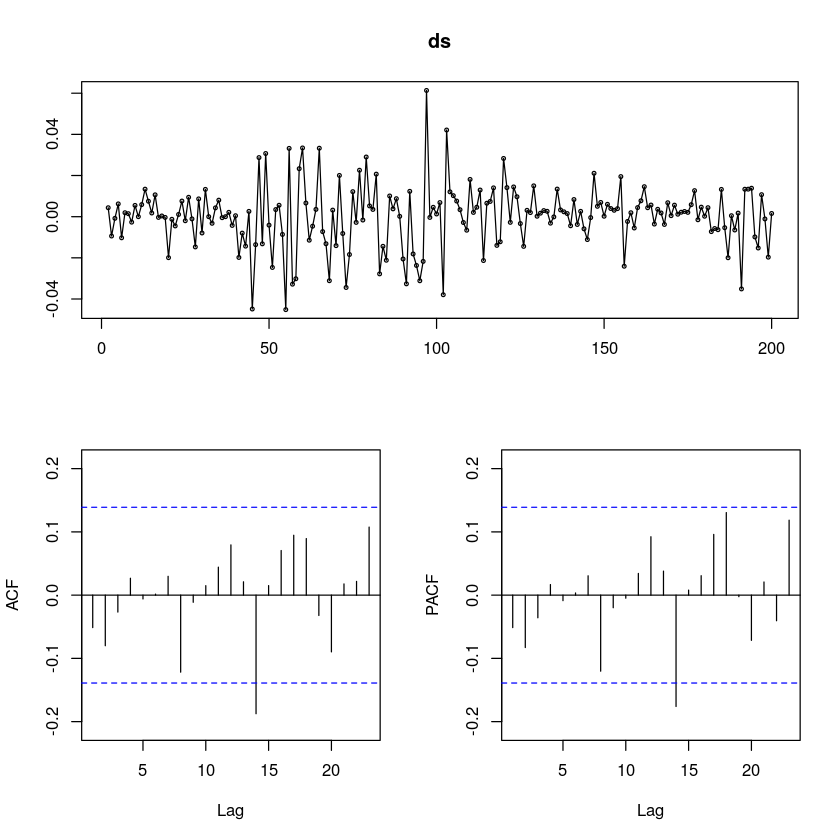

In [13]:
tsdisplay(s)
tsdisplay(ds)

In [14]:
fit <- auto.arima(s, seasonal=FALSE)
fit

Series: s 
ARIMA(0,1,0) 

sigma^2 estimated as 0.0002187:  log likelihood=556.24
AIC=-1110.47   AICc=-1110.45   BIC=-1107.18

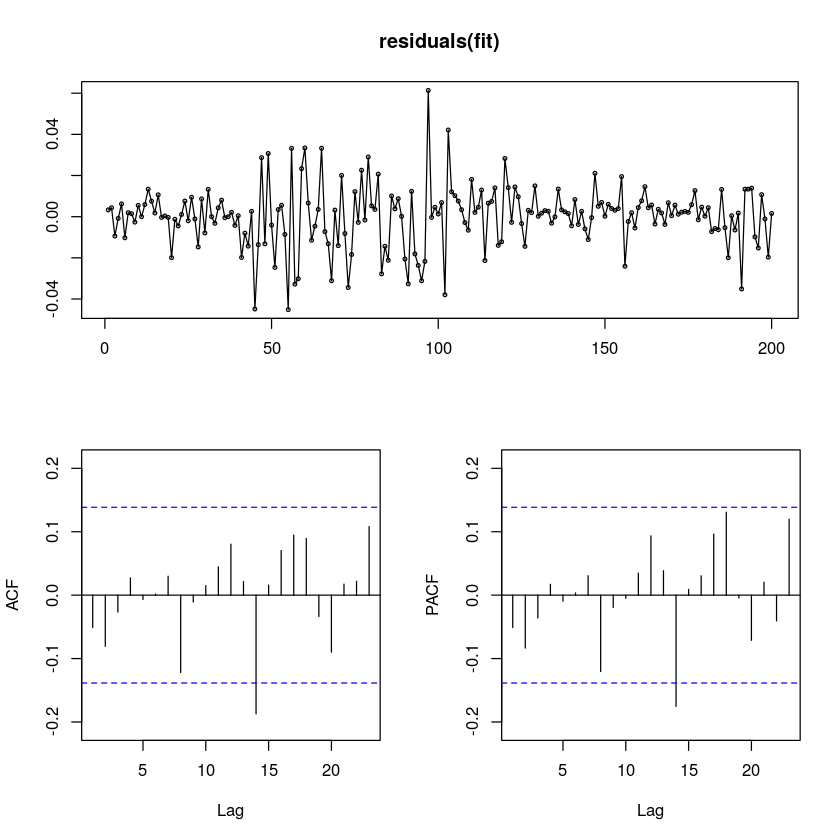

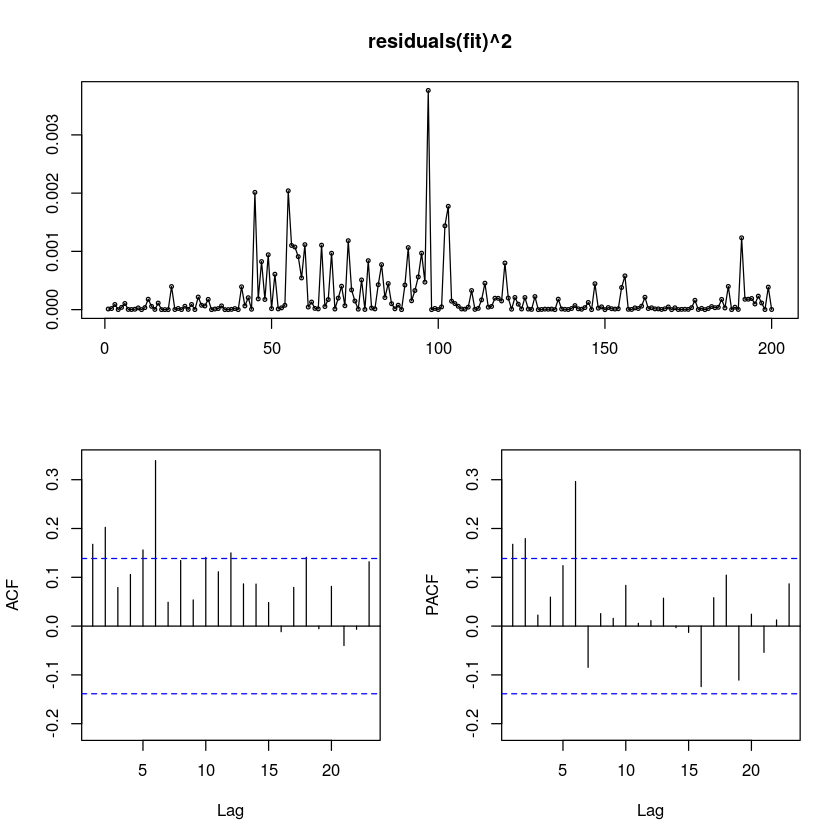

In [15]:
tsdisplay(residuals(fit))
tsdisplay(residuals(fit)^2)

In [16]:
garchSpec <- ugarchspec(variance.model=list(model="sGARCH",
                               garchOrder=c(2,2)),
           mean.model=list(armaOrder=c(0,0)), 
           distribution.model="std")

garchFit <- ugarchfit(spec=garchSpec, data=ds)

In [17]:
garchFit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(2,2)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001322    0.000685 1.930482 0.053547
omega   0.000010    0.000009 1.145520 0.251994
alpha1  0.090194    0.069084 1.305578 0.191696
alpha2  0.280453    0.100644 2.786589 0.005327
beta1   0.000019    0.104590 0.000182 0.999855
beta2   0.628333    0.108617 5.784854 0.000000
shape   4.604648    1.887538 2.439500 0.014708

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001322    0.000823 1.606545 0.108154
omega   0.000010    0.000010 1.064136 0.287267
alpha1  0.090194    0.062479 1.443593 0.148853
alpha2  0.280453    0.093540 2.998229 0.002716
beta1   0.000019    0.061746 0.000308 0.999754
beta2   0

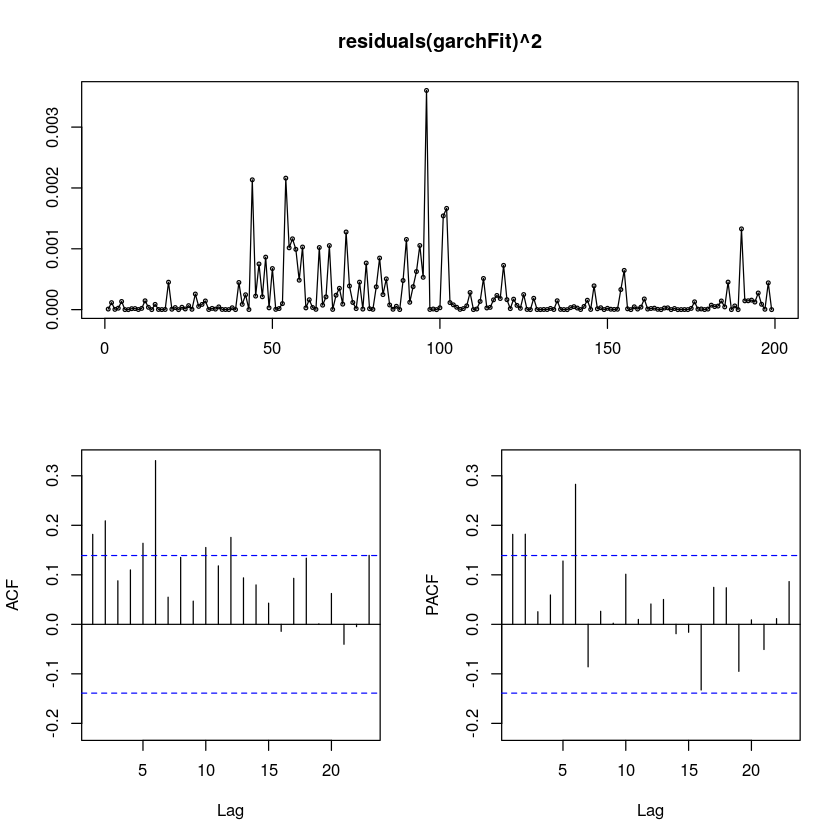

In [18]:
tsdisplay(residuals(garchFit)^2)

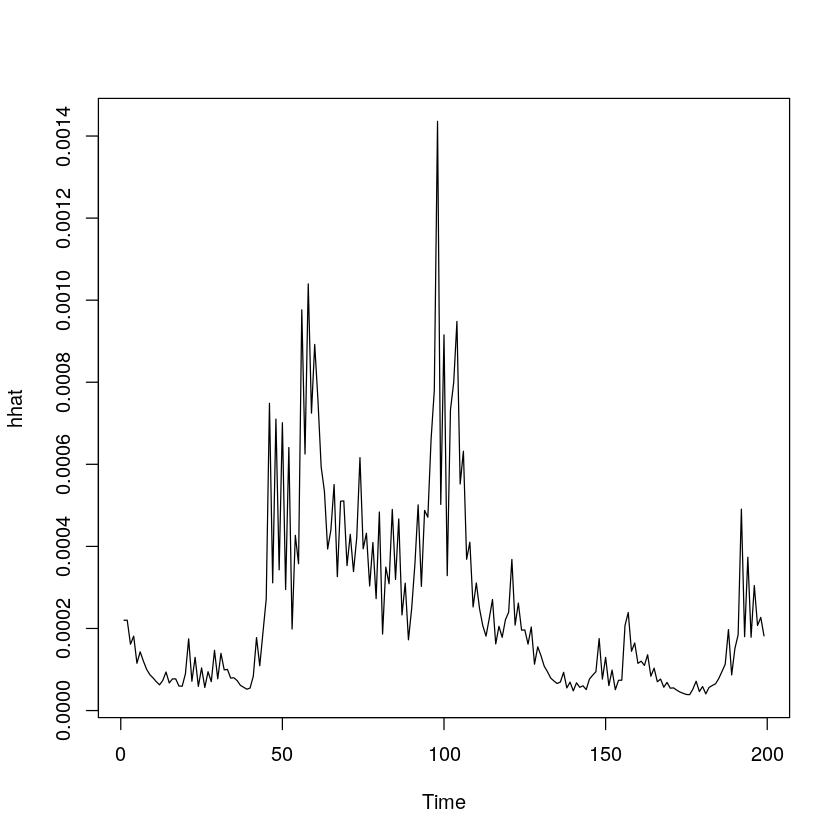

In [19]:
hhat <- ts(garchFit@fit$sigma^2)
plot.ts(hhat)